In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('D:/ML_2/Final_Recipe_Rec/dataset_for_model.csv')

In [ ]:
df.head()
##Cai nay de test git thoi 

,Calories,Fat,Saturates,Sugars,Salt,Protein,Carbs,Fibre,acorn squash,aioli,...,Main Ingredient_Sweets Recipes,Main Ingredient_Tofu,Main Ingredient_Tomato,Main Ingredient_Turkey,Main Ingredient_Venison,Main Ingredient_Chicken,Main Ingredient_Egg,Main Ingredient_Vegetable,Main Ingredient_Pie,None
0,0.106719,0.083502,0.085492,0.000000,0.141,0.140159,0.000000,0.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.347826,0.146128,0.119171,0.055351,0.290,0.359841,0.284625,0.134615,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.218709,0.079461,0.095855,0.026753,0.000,0.239563,0.207751,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.101449,0.053199,0.067358,0.042435,0.020,0.027833,0.125159,0.033654,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.251647,0.111111,0.072539,0.013838,0.000,0.248509,0.202668,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0


Model mình dùng sẽ là random forest -> Có cột Cook time minutes thôi không cần chuẩn hóa cũng được, không log mấy cái dinh dưỡng, nếu dùng thêm model khác mình sẽ làm sau

Dùng gridsearchCV hoặc randomizedsearchCV để tìm ra bộ hyperparameter oke nhất đã

In [3]:
import numpy as np
import pandas as pd
import joblib
import time
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Chuẩn bị dữ liệu
# X là tất cả các đặc trưng
X = df.drop(columns=['Weight_Loss', 'Bodybuilder', 'CleanEating', 'Diabetic', 'Hypertension',
                    'Heart-Healthy Diet', 'Vegetarian', 'Low_Carb', 'None'])

# y là các cột mục tiêu (multi-targets)
y = df[['Weight_Loss', 'Bodybuilder', 'CleanEating', 'Diabetic', 'Hypertension',
        'Heart-Healthy Diet', 'Vegetarian', 'Low_Carb', 'None']]

print(f"Kích thước dữ liệu: X={X.shape}, y={y.shape}")
print(f"Số lượng features: {X.shape[1]}")
print(f"Số lượng targets: {y.shape[1]}")

# Phân tích cấu trúc target
def analyze_target_structure(y_data):
    """Phân tích và xác nhận cấu trúc dữ liệu target"""
    if isinstance(y_data, pd.DataFrame):
        y_array = y_data.values
    else:
        y_array = y_data
        
    print(f"\nPhân tích target structure:")
    print(f"Shape của y: {y_array.shape}")
    
    # Kiểm tra từng target
    for i, col in enumerate(y_data.columns if isinstance(y_data, pd.DataFrame) else range(y_array.shape[1])):
        unique_vals = np.unique(y_array[:, i])
        print(f"Target {col}: {unique_vals}")
    
    # Kiểm tra label distribution
    print("\nLabel distribution:")
    if isinstance(y_data, pd.DataFrame):
        print(y_data.sum().sort_values(ascending=False))
    
    unique_vals = np.unique(y_array)
    is_binary = set(unique_vals).issubset({0, 1})
    
    if is_binary:
        print("✓ Xác nhận: Multi-label binary classification")
        return "multilabel", y_array
    else:
        raise ValueError("Dữ liệu target không phải dạng nhị phân (0/1)")

# Phân tích target
problem_type, y_processed = analyze_target_structure(y)
print(f"Loại bài toán: {problem_type}")

# Chia dữ liệu train/validation/test
print("\n" + "="*50)
print("CHIA DỮ LIỆU")
print("="*50)

# Chia train/test (80/20)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y_processed, test_size=0.2, random_state=42, shuffle=True
)

# Chia train/validation (60/20 từ tổng dataset)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, shuffle=True
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}") 
print(f"Test set: {X_test.shape}")

# Khởi tạo model và CV strategy
print("\n" + "="*50)
print("THIẾT LẬP MODEL VÀ CROSS-VALIDATION")
print("="*50)

base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
model = MultiOutputClassifier(base_model, n_jobs=-1)  # Thêm n_jobs cho MultiOutputClassifier

# Sử dụng f1_macro cho multi-label imbalanced data
scoring_metric = 'f1_macro'
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"Scoring metric: {scoring_metric}")
print(f"CV strategy: {cv_strategy}")

# GridSearch tối ưu - chia làm 2 bước
print("\n" + "="*50)
print("BƯỚC 1: TÌM N_ESTIMATORS TỐI ƯU")
print("="*50)

# Bước 1: Tìm n_estimators với range rộng hơn
param_grid_coarse = {
    'estimator__n_estimators': [100, 200, 300, 500],  # Tăng range
    'estimator__random_state': [42]  # Fix random_state
}

grid_coarse = GridSearchCV(
    estimator=model,
    param_grid=param_grid_coarse,
    cv=cv_strategy,
    scoring=scoring_metric,
    n_jobs=-1,
    verbose=2,  # Tăng verbose để theo dõi tiến trình
    return_train_score=True
)

start_time = time.time()
grid_coarse.fit(X_train, y_train)
coarse_time = time.time() - start_time

print(f"\nThời gian tìm kiếm coarse: {coarse_time:.2f}s")
print(f"Best n_estimators: {grid_coarse.best_params_['estimator__n_estimators']}")
print(f"Best score: {grid_coarse.best_score_:.4f}")

# Bước 2: Fine-tuning với n_estimators tốt nhất
print("\n" + "="*50)
print("BƯỚC 2: FINE-TUNING CÁC THAM SỐ")
print("="*50)

best_n_estimators = grid_coarse.best_params_['estimator__n_estimators']

param_grid_fine = {
    'estimator__n_estimators': [best_n_estimators],
    'estimator__max_depth': [None, 15, 25, 35],  # Tối ưu cho dataset lớn
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4], 
    'estimator__max_features': ['sqrt', 'log2', None],  # Thêm None option
    'estimator__random_state': [42]
}

# Sử dụng RandomizedSearch thay vì GridSearch để tăng tốc
from sklearn.model_selection import RandomizedSearchCV

grid_fine = RandomizedSearchCV(  # Đổi sang RandomizedSearch
    estimator=model,
    param_distributions=param_grid_fine,  # param_distributions thay vì param_grid
    n_iter=50,  # Số lần thử random
    cv=cv_strategy,
    scoring=scoring_metric,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

start_time = time.time()
grid_fine.fit(X_train, y_train)
fine_time = time.time() - start_time

print(f"\nThời gian fine-tuning: {fine_time:.2f}s")
print(f"Tổng thời gian training: {(coarse_time + fine_time):.2f}s")
print(f"Best parameters: {grid_fine.best_params_}")
print(f"Best CV score: {grid_fine.best_score_:.4f}")

# Lưu model ngay sau khi train xong
print("\n" + "="*50)
print("LƯU MODEL")
print("="*50)

best_model = grid_fine.best_estimator_

# Lưu model
joblib.dump(best_model, 'best_randomized_search_CV.pkl')
print("✓ Đã lưu model nke")

# Lưu thông tin cơ bản về training
training_info = {
    'best_params': grid_fine.best_params_,
    'best_cv_score': grid_fine.best_score_,
    'training_time_seconds': coarse_time + fine_time,
    'data_shape': {
        'X_train': X_train.shape,
        'X_val': X_val.shape,
        'X_test': X_test.shape
    },
    'target_names': ['Weight_Loss', 'Bodybuilder', 'CleanEating', 'Diabetic', 'Hypertension',
                     'Heart-Healthy Diet', 'Vegetarian', 'Low_Carb', 'None'],
    'feature_count': X_train.shape[1]
}

import json
with open('training_info.json', 'w') as f:
    json.dump(training_info, f, indent=2)

print("✓ Đã lưu thông tin training: training_info.json")
print(f"\nBest CV Score: {grid_fine.best_score_:.4f}")
print(f"Total Training Time: {(coarse_time + fine_time):.2f}s")
print(f"Best Parameters: {grid_fine.best_params_}")

print("\n" + "="*50)
print("hẹ hẹ hẹ")

Kích thước dữ liệu: X=(3120, 797), y=(3120, 9)
Số lượng features: 797
Số lượng targets: 9

Phân tích target structure:
Shape của y: (3120, 9)
Target Weight_Loss: [0 1]
Target Bodybuilder: [0 1]
Target CleanEating: [0 1]
Target Diabetic: [0 1]
Target Hypertension: [0 1]
Target Heart-Healthy Diet: [0 1]
Target Vegetarian: [0 1]
Target Low_Carb: [0 1]
Target None: [0 1]

Label distribution:
None                  1040
Bodybuilder            604
Hypertension           575
Low_Carb               540
Weight_Loss            433
CleanEating            413
Vegetarian             391
Diabetic               312
Heart-Healthy Diet     301
dtype: int64
✓ Xác nhận: Multi-label binary classification
Loại bài toán: multilabel

CHIA DỮ LIỆU
Training set: (1872, 797)
Validation set: (624, 797)
Test set: (624, 797)

THIẾT LẬP MODEL VÀ CROSS-VALIDATION
Scoring metric: f1_macro
CV strategy: KFold(n_splits=5, random_state=42, shuffle=True)

BƯỚC 1: TÌM N_ESTIMATORS TỐI ƯU
Fitting 5 folds for each of 4 candid

LOAD MODEL VÀ ĐÁNH GIÁ
✓ Đã load model thành công
✓ Đã load thông tin training

Thông tin model:
- Best CV Score: 0.9008
- Training Time: 407.85s
- Số features: 797
- Best Parameters: {'estimator__random_state': 42, 'estimator__n_estimators': 200, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_features': None, 'estimator__max_depth': None}

CHUẨN BỊ DỮ LIỆU ĐÁNH GIÁ
Validation set shape: (624, 797)
Test set shape: (624, 797)

ĐÁNH GIÁ TRÊN VALIDATION SET
Validation Metrics:
- Hamming Loss: 0.0296
- Subset Accuracy: 0.7772
- F1 Macro: 0.8952
- F1 Micro: 0.9094

ĐÁNH GIÁ TRÊN TEST SET
Test Metrics:
- Hamming Loss: 0.0310
- Subset Accuracy: 0.7596
- F1 Macro: 0.8964
- F1 Micro: 0.9005

CLASSIFICATION REPORT CHO TỪNG TARGET (TEST SET)

--- Weight_Loss ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       542
           1       1.00      0.99      0.99        82

    accuracy                        

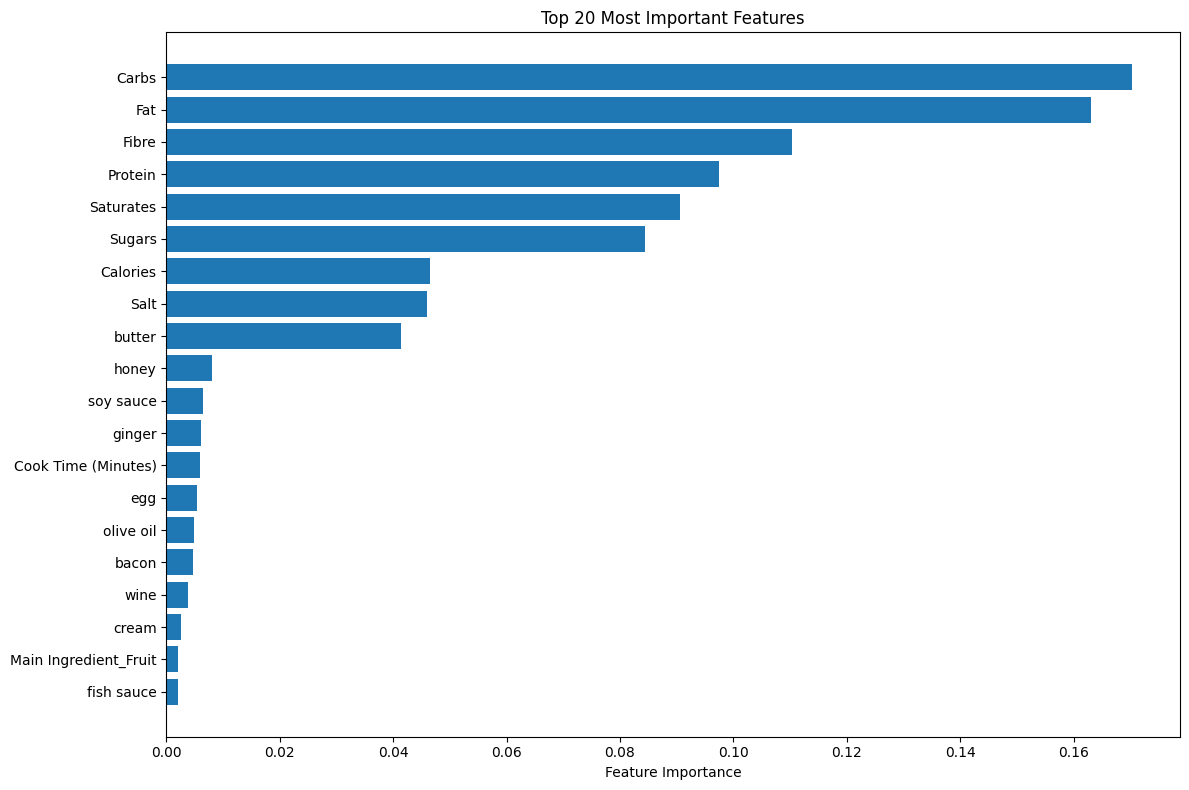

✓ Đã lưu biểu đồ feature importance: feature_importance_plot.png

HOÀN THÀNH ĐÁNH GIÁ MODEL!
Model performance summary:
- Test F1 Macro: 0.8964
- Test Subset Accuracy: 0.7596
- Test Hamming Loss: 0.0310


In [4]:
import numpy as np
import pandas as pd
import joblib
import json
from sklearn.metrics import classification_report, hamming_loss, accuracy_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load model và thông tin training
print("="*60)
print("LOAD MODEL VÀ ĐÁNH GIÁ")
print("="*60)

# Load model
try:
    best_model = joblib.load('best_randomized_search_CV.pkl')
    print("✓ Đã load model thành công")
except FileNotFoundError:
    print("❌ Không tìm thấy file model. Hãy chạy script training trước.")
    exit()

# Load training info
try:
    with open('training_info.json', 'r') as f:
        training_info = json.load(f)
    print("✓ Đã load thông tin training")
except FileNotFoundError:
    print("⚠️ Không tìm thấy file training_info.json")
    training_info = None

# Hiển thị thông tin model
if training_info:
    print(f"\nThông tin model:")
    print(f"- Best CV Score: {training_info['best_cv_score']:.4f}")
    print(f"- Training Time: {training_info['training_time_seconds']:.2f}s")
    print(f"- Số features: {training_info['feature_count']}")
    print(f"- Best Parameters: {training_info['best_params']}")

# Chuẩn bị dữ liệu để đánh giá (giống như trong script training)
# Giả sử bạn đã có df và đã chia dữ liệu
print(f"\n" + "="*60)
print("CHUẨN BỊ DỮ LIỆU ĐÁNH GIÁ")
print("="*60)

# Chuẩn bị dữ liệu (copy từ script training)
X = df.drop(columns=['Weight_Loss', 'Bodybuilder', 'CleanEating', 'Diabetic', 'Hypertension',
                    'Heart-Healthy Diet', 'Vegetarian', 'Low_Carb', 'None'])
y = df[['Weight_Loss', 'Bodybuilder', 'CleanEating', 'Diabetic', 'Hypertension',
        'Heart-Healthy Diet', 'Vegetarian', 'Low_Carb', 'None']].values

# Chia dữ liệu với cùng random_state để có cùng split
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, shuffle=True
)

print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Đánh giá trên validation set
print(f"\n" + "="*60)
print("ĐÁNH GIÁ TRÊN VALIDATION SET")
print("="*60)

y_val_pred = best_model.predict(X_val)

# Tính các metrics
hamming_val = hamming_loss(y_val, y_val_pred)
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_macro_val = f1_score(y_val, y_val_pred, average='macro')
f1_micro_val = f1_score(y_val, y_val_pred, average='micro')

print(f"Validation Metrics:")
print(f"- Hamming Loss: {hamming_val:.4f}")
print(f"- Subset Accuracy: {accuracy_val:.4f}")
print(f"- F1 Macro: {f1_macro_val:.4f}")
print(f"- F1 Micro: {f1_micro_val:.4f}")

# Đánh giá trên test set
print(f"\n" + "="*60)
print("ĐÁNH GIÁ TRÊN TEST SET")
print("="*60)

y_test_pred = best_model.predict(X_test)

# Tính các metrics cho test set
hamming_test = hamming_loss(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test, y_test_pred, average='micro')

print(f"Test Metrics:")
print(f"- Hamming Loss: {hamming_test:.4f}")
print(f"- Subset Accuracy: {accuracy_test:.4f}")
print(f"- F1 Macro: {f1_macro_test:.4f}")
print(f"- F1 Micro: {f1_micro_test:.4f}")

# Classification report cho từng target
target_names = ['Weight_Loss', 'Bodybuilder', 'CleanEating', 'Diabetic', 'Hypertension',
                'Heart-Healthy Diet', 'Vegetarian', 'Low_Carb', 'None']

print(f"\n" + "="*60)
print("CLASSIFICATION REPORT CHO TỪNG TARGET (TEST SET)")
print("="*60)

target_metrics = []
for i, target in enumerate(target_names):
    print(f"\n--- {target} ---")
    report = classification_report(y_test[:, i], y_test_pred[:, i], 
                                 output_dict=True, zero_division=0)
    print(classification_report(y_test[:, i], y_test_pred[:, i], zero_division=0))
    
    # Lưu metrics cho target này
    target_metrics.append({
        'target': target,
        'precision': report['1']['precision'] if '1' in report else 0,
        'recall': report['1']['recall'] if '1' in report else 0,
        'f1': report['1']['f1-score'] if '1' in report else 0,
        'support': report['1']['support'] if '1' in report else 0
    })

# Tạo DataFrame với metrics cho từng target
target_metrics_df = pd.DataFrame(target_metrics)
print(f"\nTổng hợp metrics cho từng target:")
print(target_metrics_df.round(4))

# Feature importance analysis
print(f"\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Lấy feature importance trung bình từ tất cả các estimators
feature_importances = []
for estimator in best_model.estimators_:
    feature_importances.append(estimator.feature_importances_)

avg_importance = np.mean(feature_importances, axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': avg_importance
}).sort_values('importance', ascending=False)

print("Top 15 features quan trọng nhất:")
print(feature_importance_df.head(15))

# Lưu kết quả đánh giá
print(f"\n" + "="*60)
print("LƯU KẾT QUẢ ĐÁNH GIÁ")
print("="*60)

# Lưu feature importance
feature_importance_df.to_csv('feature_importance.csv', index=False)
print("✓ Đã lưu feature importance: feature_importance.csv")

# Lưu target metrics
target_metrics_df.to_csv('target_metrics.csv', index=False)
print("✓ Đã lưu target metrics: target_metrics.csv")

# Lưu kết quả đánh giá tổng hợp
evaluation_results = {
    'validation_metrics': {
        'hamming_loss': hamming_val,
        'subset_accuracy': accuracy_val,
        'f1_macro': f1_macro_val,
        'f1_micro': f1_micro_val
    },
    'test_metrics': {
        'hamming_loss': hamming_test,
        'subset_accuracy': accuracy_test,
        'f1_macro': f1_macro_test,
        'f1_micro': f1_micro_test
    },
    'target_metrics': target_metrics_df.to_dict('records')
}

with open('evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2)
print("✓ Đã lưu kết quả đánh giá: evaluation_results.json")

# Visualize top features (nếu có matplotlib)
try:
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Đã lưu biểu đồ feature importance: feature_importance_plot.png")
except ImportError:
    print("⚠️ Matplotlib không có sẵn, bỏ qua việc tạo biểu đồ")

print(f"\n" + "="*60)
print("HOÀN THÀNH ĐÁNH GIÁ MODEL!")
print("="*60)
print(f"Model performance summary:")
print(f"- Test F1 Macro: {f1_macro_test:.4f}")
print(f"- Test Subset Accuracy: {accuracy_test:.4f}")
print(f"- Test Hamming Loss: {hamming_test:.4f}")

In [5]:
# 1. Kiểm feature leakage
for lbl in ['Bodybuilder','CleanEating']:
    corrs = X.corrwith(df[lbl]).abs().sort_values(ascending=False).head(5)
    print(f'\nTop corr with {lbl}:'); print(corrs)

# 2. Re-split khác random_state
from sklearn.metrics import f1_score
for rs in [7, 13, 21]:
    _, X_te, _, y_te = train_test_split(X, y, test_size=0.2, random_state=rs, shuffle=True)
    y_pred = best_model.predict(X_te)
    print(f'RS {rs} – F1 Bodybuilder:', f1_score(y_te[:,1], y_pred[:,1]))



Top corr with Bodybuilder:
Protein                  0.151057
Carbs                    0.144384
salt                     0.138175
Main Ingredient_Pasta    0.130133
Saturates                0.121294
dtype: float64

Top corr with CleanEating:
Fibre        0.323101
Sugars       0.182672
Salt         0.173961
olive oil    0.167284
Saturates    0.163551
dtype: float64
RS 7 – F1 Bodybuilder: 1.0
RS 13 – F1 Bodybuilder: 1.0
RS 21 – F1 Bodybuilder: 1.0
